In [1]:
"""
Autohr: Sergi Mas Pujol
Last update: 09/03/2021

Python version: 3.6
"""

'\nAutohr: Sergi Mas Pujol\nLast update: 09/03/2021\n\nPython version: 3.6\n'

In [2]:
import numpy as np
np.random.seed(4)
import sys
import math
import random
random.seed(7)
from random import sample
from datetime import datetime, timedelta, date
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]

from utils_samplesTraining import read_REGULATIONS_file
from utils_timeProcessing import from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots, \
                                 substract_minutes_given_HHSSMM, add_minutes_given_HHSSMM, \
                                 from_YYYYMMDD_to_DDMMYYYY_given_separator, \
                                 listDays_betweenTwoDates, \
                                 from_YYYYMMDDHHMMSS_to_HHMMSS
from utils_samplesTraining import readAssociatedFile_fromAIRAC_givenDate, \
                                  extract_regulations,\
                                  addIntervals_toFinalConjunt
from generator import extract_days_timestamps_volumes_labels_days_with_regulations, \
                      extract_features_from_list_days_and_timestamps

from generator_weather import extract_weather_information_from_list_days_and_timestamps

In [3]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, TimeDistributed

from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [4]:
# sectorName = 'LFE4H'
# sectorName = 'LFEUXR'
# sectorName = 'LFE4E'
# sectorName = 'LFE4N'

In [5]:
# Given the start timestamp of the regulation -> Considered time before and after
# Temporal gaps in minutes
gap_before_start_time = 0
gap_after_start_time = 30

In [6]:
num_epochs = 200
batch_size = 32

num_additional_samples_per_day = 50

In [7]:
num_weather_features = 16
num_metric_per_weather_feature = 3

# Prepare / Extreact data

###  Extract the available regulations

In [8]:
# Read all the available regulations
REGULATIONS = pd.read_csv('./20190523_20190911_REGULATIONS_REIMS.csv',
                          sep=";", header=None, engine='c', low_memory=False, skiprows=[0])
REGULATIONS.columns=['date_DDMMYYYY', 'regulation_ID','traffic_volume', 'start_regulations_HHMMSS', 
                     'end_regulations_HHMMSS', 'regulation_reason']

FileNotFoundError: [Errno 2] File b'./20190523_20190911_REGULATIONS_REIMS.csv' does not exist: b'./20190523_20190911_REGULATIONS_REIMS.csv'

In [9]:
REGULATIONS_from_given_sector = REGULATIONS.loc[(REGULATIONS["traffic_volume"] == sectorName) &
                                                (REGULATIONS["regulation_reason"].isin(['W-WEATHER']))]

In [10]:
print('Number regulations AFTER pre-processing: ', str(len(REGULATIONS_from_given_sector.values)))

Number regulations AFTER pre-processing:  21


In [11]:
REGULATIONS_from_given_sector

,date_DDMMYYYY,regulation_ID,traffic_volume,start_regulations_HHMMSS,end_regulations_HHMMSS,regulation_reason
137,03/06/2019,E4H03,LFE4H,122000,182000,W-WEATHER
162,05/06/2019,E4H05A,LFE4H,150000,210000,W-WEATHER
197,07/06/2019,E4H07,LFE4H,94000,124000,W-WEATHER
198,07/06/2019,E4H07A,LFE4H,140000,180000,W-WEATHER
341,19/06/2019,E4H19A,LFE4H,164000,190000,W-WEATHER
347,20/06/2019,E4H20A,LFE4H,150000,172000,W-WEATHER
360,21/06/2019,E4H21N,LFE4H,192000,214000,W-WEATHER
377,22/06/2019,E4H22A,LFE4H,110000,170000,W-WEATHER
522,01/07/2019,E4H01,LFE4H,80000,134000,W-WEATHER
523,01/07/2019,E4H01A,LFE4H,142000,174000,W-WEATHER


### Extract the different list of days and timestamps

In [12]:
min_date = date(2019, 6, 4)
max_date = date(2019, 9, 11) 

##### Samples without regulations from days without regulations

In [13]:
# Extract the days with regulations
list_days_with_regulations = REGULATIONS_from_given_sector["date_DDMMYYYY"].values

# Initialize a list with all the possible days and the final list for the days without regulations
list_all_possible_days = listDays_betweenTwoDates(min_date, max_date, 'DDMMYYYY', '/')
list_days_without_regulations = list()

In [14]:
# If a day does not appear in the list with reguilations -> No regulations for that day
for day in list_all_possible_days:
    if day not in list_days_with_regulations:
        list_days_without_regulations.append(day)

In [15]:
# For the days without regulations, we will generate random timestamps

list_days_without_regulations_extended = list()
start_time_samples_no_regulations = list()
end_time_samples_no_regulations = list()

for day in list_days_without_regulations:
    # Iterate multiple time each day without regulations
    for _ in range(0,1):
        # Randomly create the hour and the minutes
        hour = str("{:02d}".format(random.randint(3,21))) # From 2 to 22 to avoid extrems (wrap around timestamps)
        minute = str("{:02d}".format(random.randint(0,50)))

        # Create the timestamp
        random_timestamps = hour + ":" + minute + ":" + '00'

        # Append the day of the timestamp
        list_days_without_regulations_extended.append(day)
        
        # Substract a given about to create the starting timestamp
        start_timestamp = substract_minutes_given_HHSSMM(random_timestamps, gap_before_start_time)
        start_time_samples_no_regulations.append(start_timestamp)

        # Add a given about to create the ending timestamp
        end_timestamp = add_minutes_given_HHSSMM(random_timestamps, gap_after_start_time)
        end_time_samples_no_regulations.append(end_timestamp)

In [16]:
len(list_days_without_regulations_extended), len(start_time_samples_no_regulations), \
len(end_time_samples_no_regulations)

(85, 85, 85)

##### Sample with & without regulations from days with regulations completly random 
##### It is possible to have sample with both categories (e.g. start NO Regs from Regs and then Reg)

In [17]:
list_dates_with_regulations = REGULATIONS_from_given_sector["date_DDMMYYYY"].values

start_regulations = REGULATIONS_from_given_sector["start_regulations_HHMMSS"].values
end_regulations = REGULATIONS_from_given_sector["end_regulations_HHMMSS"].values

list_volumes_regulations = REGULATIONS_from_given_sector["traffic_volume"].values

In [18]:
list_days_from_regulations, \
start_time_samples_days_from_regulations, \
end_time_samples_days_from_regulations, \
volumes_days_from_regulations, \
labels_days_from_regulations = extract_days_timestamps_volumes_labels_days_with_regulations(
                                          list_dates_with_regulations, 
                                          start_regulations,
                                          end_regulations,
                                          list_volumes_regulations, 
                                          gap_before_start_time, 
                                          gap_after_start_time, 
                                          num_additional_samples_per_day=num_additional_samples_per_day,
                                          min_timestamps_with_regulations=10)

In [19]:
len(list_days_from_regulations), len(start_time_samples_days_from_regulations), \
len(end_time_samples_days_from_regulations), len(volumes_days_from_regulations)

(375, 375, 375, 375)

In [20]:
len(list_days_from_regulations)

375

In [21]:
labels_days_from_regulations.shape

(375, 30, 1)

In [22]:
labels_days_from_regulations.shape[0]*labels_days_from_regulations.shape[1]

11250

In [23]:
np.sum(labels_days_from_regulations)

7178

# Extract all the features for the given dates and timestamps

In [24]:
list_days_without_regulations_extended = np.array(list_days_without_regulations_extended)
start_time_samples_no_regulations = np.array(start_time_samples_no_regulations)
end_time_samples_no_regulations = np.array(end_time_samples_no_regulations)

In [25]:
X_days_without_regulations = np.zeros((len(list_days_without_regulations_extended), 
                                       int(gap_before_start_time+gap_after_start_time), 
                                       11))
X_days_without_regulations.shape

(85, 30, 11)

In [26]:
X_days_without_regulations = extract_features_from_list_days_and_timestamps(
                                            list_days_without_regulations_extended, 
                                            start_time_samples_no_regulations, 
                                            end_time_samples_no_regulations,
                                            sectorName,
                                            gap_before_start_time, gap_after_start_time,
                                            X_days_without_regulations)

LFE4H | counter: 1
LFE4H | counter: 2
LFE4H | counter: 3
LFE4H | counter: 4
LFE4H | counter: 5
LFE4H | counter: 6
LFE4H | counter: 7
LFE4H | counter: 8
LFE4H | counter: 9
LFE4H | counter: 10
LFE4H | counter: 11
LFE4H | counter: 12
LFE4H | counter: 13
LFE4H | counter: 14
LFE4H | counter: 15
LFE4H | counter: 16
LFE4H | counter: 17
LFE4H | counter: 18
LFE4H | counter: 19
LFE4H | counter: 20
LFE4H | counter: 21
LFE4H | counter: 22
LFE4H | counter: 23
LFE4H | counter: 24
LFE4H | counter: 25
LFE4H | counter: 26
LFE4H | counter: 27
LFE4H | counter: 28
LFE4H | counter: 29
LFE4H | counter: 30
LFE4H | counter: 31
LFE4H | counter: 32
LFE4H | counter: 33
LFE4H | counter: 34
LFE4H | counter: 35
LFE4H | counter: 36
LFE4H | counter: 37
LFE4H | counter: 38
LFE4H | counter: 39
LFE4H | counter: 40
LFE4H | counter: 41
LFE4H | counter: 42
LFE4H | counter: 43
LFE4H | counter: 44
LFE4H | counter: 45
LFE4H | counter: 46
LFE4H | counter: 47
LFE4H | counter: 48
LFE4H | counter: 49
LFE4H | counter: 50
LFE4H | c

In [27]:
np.save('./Counting_variables/X_days_without_regulations', X_days_without_regulations)

In [28]:
list_days_from_regulations = np.array(list_days_from_regulations)
start_time_samples_days_from_regulations = np.array(start_time_samples_days_from_regulations)
end_time_samples_days_from_regulations = np.array(end_time_samples_days_from_regulations)

In [29]:
X_days_from_regulations = np.zeros((len(list_days_from_regulations), 
                                    int(gap_before_start_time+gap_after_start_time), 
                                    11))
X_days_from_regulations.shape

(375, 30, 11)

In [30]:
X_days_from_regulations = extract_features_from_list_days_and_timestamps(list_days_from_regulations, 
                                                                       start_time_samples_days_from_regulations, 
                                                                       end_time_samples_days_from_regulations,
                                                                       sectorName,
                                                                       gap_before_start_time, gap_after_start_time,
                                                                       X_days_from_regulations)

LFE4H | counter: 1
LFE4H | counter: 2
LFE4H | counter: 3
LFE4H | counter: 4
LFE4H | counter: 5
LFE4H | counter: 6
LFE4H | counter: 7
LFE4H | counter: 8
LFE4H | counter: 9
LFE4H | counter: 10
LFE4H | counter: 11
LFE4H | counter: 12
LFE4H | counter: 13
LFE4H | counter: 14
LFE4H | counter: 15
LFE4H | counter: 16
LFE4H | counter: 17
LFE4H | counter: 18
LFE4H | counter: 19
LFE4H | counter: 20
LFE4H | counter: 21
LFE4H | counter: 22
LFE4H | counter: 23
LFE4H | counter: 24
LFE4H | counter: 25
LFE4H | counter: 26
LFE4H | counter: 27
LFE4H | counter: 28
LFE4H | counter: 29
LFE4H | counter: 30
LFE4H | counter: 31
LFE4H | counter: 32
LFE4H | counter: 33
LFE4H | counter: 34
LFE4H | counter: 35
LFE4H | counter: 36
LFE4H | counter: 37
LFE4H | counter: 38
LFE4H | counter: 39
LFE4H | counter: 40
LFE4H | counter: 41
LFE4H | counter: 42
LFE4H | counter: 43
LFE4H | counter: 44
LFE4H | counter: 45
LFE4H | counter: 46
LFE4H | counter: 47
LFE4H | counter: 48
LFE4H | counter: 49
LFE4H | counter: 50
LFE4H | c

In [31]:
np.save('./Counting_variables/X_days_from_regulations', X_days_from_regulations)
np.save('./Counting_variables/labels_days_from_regulations', labels_days_from_regulations)

# Extract the weather features 

In [32]:
X_days_without_regulations_weather = np.zeros((len(list_days_without_regulations_extended), 
                                               int(gap_before_start_time+gap_after_start_time), 
                                               num_weather_features*num_metric_per_weather_feature))
X_days_without_regulations_weather.shape

(85, 30, 48)

In [33]:
X_days_without_regulations_weather = extract_weather_information_from_list_days_and_timestamps(
    list_days_without_regulations_extended, 
    start_time_samples_no_regulations, 
    end_time_samples_no_regulations,
    sectorName,
    num_weather_features,
    num_metric_per_weather_feature,
    X_days_without_regulations_weather)

day: 04/06/2019 | start:130900 | TV: LFE4H
day: 06/06/2019 | start:154100 | TV: LFE4H
day: 08/06/2019 | start:040400 | TV: LFE4H
day: 09/06/2019 | start:200600 | TV: LFE4H
day: 10/06/2019 | start:143700 | TV: LFE4H
day: 11/06/2019 | start:043200 | TV: LFE4H
day: 12/06/2019 | start:090200 | TV: LFE4H
day: 13/06/2019 | start:052700 | TV: LFE4H
day: 14/06/2019 | start:160400 | TV: LFE4H
day: 15/06/2019 | start:100500 | TV: LFE4H
day: 16/06/2019 | start:202700 | TV: LFE4H
day: 17/06/2019 | start:043600 | TV: LFE4H
day: 18/06/2019 | start:061400 | TV: LFE4H
day: 23/06/2019 | start:210300 | TV: LFE4H
day: 24/06/2019 | start:213700 | TV: LFE4H
day: 25/06/2019 | start:150300 | TV: LFE4H
day: 26/06/2019 | start:100200 | TV: LFE4H
day: 27/06/2019 | start:200800 | TV: LFE4H
day: 28/06/2019 | start:122600 | TV: LFE4H
day: 29/06/2019 | start:073400 | TV: LFE4H
day: 30/06/2019 | start:063600 | TV: LFE4H
day: 02/07/2019 | start:123500 | TV: LFE4H
day: 03/07/2019 | start:080600 | TV: LFE4H
day: 04/07/

In [34]:
np.save('./Counting_variables/X_days_without_regulations_weather', X_days_without_regulations_weather)

In [35]:
X_days_from_regulations_weather = np.zeros((len(list_days_from_regulations), 
                                            int(gap_before_start_time+gap_after_start_time), 
                                            num_weather_features*num_metric_per_weather_feature))
X_days_from_regulations_weather.shape

(375, 30, 48)

In [36]:
X_days_from_regulations_weather = extract_weather_information_from_list_days_and_timestamps(
    list_days_from_regulations, 
    start_time_samples_days_from_regulations, 
    end_time_samples_days_from_regulations,
    sectorName,
    num_weather_features,
    num_metric_per_weather_feature,
    X_days_from_regulations_weather)

day: 03/06/2019 | start:043900 | TV: LFE4H
day: 03/06/2019 | start:151600 | TV: LFE4H
day: 03/06/2019 | start:091400 | TV: LFE4H
day: 03/06/2019 | start:172000 | TV: LFE4H
day: 03/06/2019 | start:201600 | TV: LFE4H
day: 03/06/2019 | start:031400 | TV: LFE4H
day: 03/06/2019 | start:151900 | TV: LFE4H
day: 03/06/2019 | start:064100 | TV: LFE4H
day: 03/06/2019 | start:174000 | TV: LFE4H
day: 03/06/2019 | start:121500 | TV: LFE4H
day: 03/06/2019 | start:135000 | TV: LFE4H
day: 03/06/2019 | start:141100 | TV: LFE4H
day: 03/06/2019 | start:094800 | TV: LFE4H
day: 03/06/2019 | start:173200 | TV: LFE4H
day: 03/06/2019 | start:141500 | TV: LFE4H
day: 03/06/2019 | start:034000 | TV: LFE4H
day: 03/06/2019 | start:141500 | TV: LFE4H
day: 03/06/2019 | start:094000 | TV: LFE4H
day: 03/06/2019 | start:165000 | TV: LFE4H
day: 03/06/2019 | start:131500 | TV: LFE4H
day: 03/06/2019 | start:153900 | TV: LFE4H
day: 03/06/2019 | start:151500 | TV: LFE4H
day: 03/06/2019 | start:082000 | TV: LFE4H
day: 03/06/

day: 01/07/2019 | start:075000 | TV: LFE4H
day: 01/07/2019 | start:094400 | TV: LFE4H
day: 01/07/2019 | start:092300 | TV: LFE4H
day: 01/07/2019 | start:092800 | TV: LFE4H
day: 01/07/2019 | start:162600 | TV: LFE4H
day: 01/07/2019 | start:121300 | TV: LFE4H
day: 01/07/2019 | start:143000 | TV: LFE4H
day: 01/07/2019 | start:194000 | TV: LFE4H
day: 01/07/2019 | start:083700 | TV: LFE4H
day: 01/07/2019 | start:084100 | TV: LFE4H
day: 01/07/2019 | start:213200 | TV: LFE4H
day: 01/07/2019 | start:082800 | TV: LFE4H
day: 01/07/2019 | start:092400 | TV: LFE4H
day: 01/07/2019 | start:141600 | TV: LFE4H
day: 01/07/2019 | start:153500 | TV: LFE4H
day: 01/07/2019 | start:053700 | TV: LFE4H
day: 06/07/2019 | start:113700 | TV: LFE4H
day: 06/07/2019 | start:191900 | TV: LFE4H
day: 06/07/2019 | start:083900 | TV: LFE4H
day: 06/07/2019 | start:104200 | TV: LFE4H
day: 06/07/2019 | start:071900 | TV: LFE4H
day: 06/07/2019 | start:082500 | TV: LFE4H
day: 06/07/2019 | start:062000 | TV: LFE4H
day: 06/07/

In [37]:
np.save('./Counting_variables/X_days_from_regulations_weather', X_days_from_regulations_weather)

# Concatenate the scalar variables and the weather features

In [10]:
X_days_without_regulations = np.load('./Counting_variables/Weather/X_days_without_regulations.npy')
X_days_without_regulations_weather = np.load('./Counting_variables/Weather/X_days_without_regulations_weather.npy')

X_days_from_regulations = np.load('./Counting_variables/Weather/X_days_from_regulations.npy')
X_days_from_regulations_weather = np.load('./Counting_variables/Weather/X_days_from_regulations_weather.npy')

labels_days_from_regulations = np.load('./Counting_variables/Weather/labels_days_from_regulations.npy')

In [12]:
X_days_without_regulations_concatenate = np.zeros((X_days_without_regulations.shape[0], 
                                                   X_days_without_regulations.shape[1],
                                                   X_days_without_regulations.shape[2]+X_days_without_regulations_weather.shape[2]))

# X_days_without_regulations_concatenate = np.zeros((X_days_without_regulations.shape[0], 
#                                                    X_days_without_regulations.shape[1],
#                                                    X_days_without_regulations.shape[2]))

# X_days_without_regulations_concatenate = np.zeros((X_days_without_regulations_weather.shape[0], 
#                                                    X_days_without_regulations_weather.shape[1],
#                                                    X_days_without_regulations_weather.shape[2]+5))


X_days_without_regulations_concatenate.shape

(88, 30, 59)

In [13]:
X_days_without_regulations_concatenate[:,:,0:num_weather_features*num_metric_per_weather_feature] = X_days_without_regulations_weather
X_days_without_regulations_concatenate[:,:,num_weather_features*num_metric_per_weather_feature:] = X_days_without_regulations

# X_days_without_regulations_concatenate[:,:,num_weather_features*num_metric_per_weather_feature:] = X_days_without_regulations[:,:,0:5]

# X_days_without_regulations_concatenate = X_days_without_regulations

In [15]:
X_days_from_regulations_concatenate = np.zeros((X_days_from_regulations.shape[0], 
                                                X_days_from_regulations.shape[1],
                                                X_days_from_regulations.shape[2]+X_days_from_regulations_weather.shape[2]))

# X_days_from_regulations_concatenate = np.zeros((X_days_from_regulations.shape[0], 
#                                                 X_days_from_regulations.shape[1],
#                                                 X_days_from_regulations.shape[2]))

# X_days_from_regulations_concatenate = np.zeros((X_days_from_regulations_weather.shape[0], 
#                                                 X_days_from_regulations_weather.shape[1],
#                                                 X_days_from_regulations_weather.shape[2]+5))


X_days_from_regulations_concatenate.shape

(387, 30, 59)

In [16]:
X_days_from_regulations_concatenate[:,:,0:num_weather_features*num_metric_per_weather_feature] = X_days_from_regulations_weather
X_days_from_regulations_concatenate[:,:,num_weather_features*num_metric_per_weather_feature:] = X_days_from_regulations

# X_days_from_regulations_concatenate[:,:,num_weather_features*num_metric_per_weather_feature:] = X_days_from_regulations[:,:,0:5]

# X_days_from_regulations_concatenate = X_days_from_regulations

In [17]:
X_days_from_regulations_concatenate.shape

(387, 30, 59)

# Create the labels

In [18]:
Y_days_without_regulations = np.zeros((X_days_without_regulations.shape[0], (gap_before_start_time+gap_after_start_time), 1), dtype=int)

In [19]:
Y_days_without_regulations.shape

(88, 30, 1)

In [20]:
Y_from_regulations = np.zeros((X_days_from_regulations.shape[0], (gap_before_start_time+gap_after_start_time), 1), dtype=int)

In [21]:
Y_from_regulations = labels_days_from_regulations

In [22]:
Y_from_regulations.shape

(387, 30, 1)

# Split into training & testing - By day

In [23]:
X_days_without_regulations_concatenate.shape, Y_days_without_regulations.shape

((88, 30, 59), (88, 30, 1))

In [24]:
X_days_from_regulations_concatenate.shape, Y_from_regulations.shape

((387, 30, 59), (387, 30, 1))

In [25]:
num_train_samples_days_without_regulations = int(np.floor(X_days_without_regulations_concatenate.shape[0]*0.7))
num_train_samples_days_without_regulations

61

In [26]:
num_train_samples_days_from_regulations = int(np.floor(X_days_from_regulations_concatenate.shape[0]*0.7))
num_train_samples_days_from_regulations

270

In [27]:
X_train = np.concatenate((X_days_without_regulations_concatenate[0:num_train_samples_days_without_regulations],
                          X_days_from_regulations_concatenate[0:num_train_samples_days_from_regulations]))

y_train = np.concatenate((Y_days_without_regulations[0:num_train_samples_days_without_regulations],
                          Y_from_regulations[0:num_train_samples_days_from_regulations]))

In [28]:
X_train.shape, y_train.shape

((331, 30, 59), (331, 30, 1))

In [29]:
X_test = np.concatenate((X_days_without_regulations_concatenate[num_train_samples_days_without_regulations:],
                         X_days_from_regulations_concatenate[num_train_samples_days_from_regulations:]))

y_test = np.concatenate((Y_days_without_regulations[num_train_samples_days_without_regulations:],
                         Y_from_regulations[num_train_samples_days_from_regulations:]))

In [30]:
X_test.shape, y_test.shape

((144, 30, 59), (144, 30, 1))

# Only using the max values form the weather features

In [31]:
X_train.shape, X_test.shape

((331, 30, 59), (144, 30, 59))

In [32]:
list_weather_features_delete = []
for i in range(num_weather_features):
    list_weather_features_delete.append(0+i*num_metric_per_weather_feature)
    list_weather_features_delete.append(1+i*num_metric_per_weather_feature)
    
# Additional elements added to the delete list
list_weather_features_delete.append(1*3-1)
list_weather_features_delete.append(3*3-1)
# list_weather_features_delete.append(4*3-1)
# list_weather_features_delete.append(11*3-1)
# list_weather_features_delete.append(3*3-1)
# list_weather_features_delete.append(3*3-1)

In [33]:
len(list_weather_features_delete)

34

In [34]:
X_train_del = np.zeros((X_train.shape[0], X_train.shape[1], X_train.shape[2]-len(list_weather_features_delete)))
X_test_del = np.zeros((X_test.shape[0], X_test.shape[1], X_train.shape[2]-len(list_weather_features_delete)))

for j in range(X_train.shape[0]):
    X_train_del[j] = np.delete(X_train[j], list_weather_features_delete, axis=1)
for j in range(X_test.shape[0]):
    X_test_del[j] = np.delete(X_test[j], list_weather_features_delete, axis=1)


In [35]:
X_train_del.shape, X_test_del.shape

((331, 30, 25), (144, 30, 25))

In [36]:
# Used it to avoid having to change the name of the variables in the following lines
X_train = X_train_del
X_test = X_test_del

# Using StandardScaler from sklearn.preprocessing

In [265]:
X_train_sc = np.reshape(X_train, (X_train.shape))
X_test_sc = np.reshape(X_test, (X_test.shape))

In [266]:
X_train_sc.shape, X_test_sc.shape

((321, 30, 19), (139, 30, 19))

In [267]:
# X_sc_train = np.zeros((X_train.shape))
# X_sc_test = np.zeros((X_test.shape))

In [268]:
# # Fit and store a scaler for each channel

# scalers = {}
# for i in range(X_train.shape[1]):
#     scalers[i] = StandardScaler()
#     X_sc_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

# for i in range(X_test.shape[1]):
#     X_sc_test[:, i, :] = scalers[i].transform(X_test[:, i, :])

# Train the model

In [270]:
from keras.layers import BatchNormalization, Bidirectional
from keras.models import Sequential

In [271]:
# num_timestamps_per_sample = gap_before_start_time + gap_after_start_time

In [272]:
# def Hotspoter_v2(input_shape):
    
#     model = Sequential()

#     model.add(LSTM(X_train.shape[2], return_sequences=True, input_shape=input_shape))
#     model.add(Dropout(0.5))
#     model.add(LSTM(X_train.shape[2]*2, return_sequences=True))
#     model.add(Dropout(0.5))
#     model.add(LSTM(X_train.shape[2], return_sequences=True))
#     model.add(Dropout(0.5))

#     model.add(TimeDistributed(Dense(1, activation='sigmoid')))
#     # model.add(Activation('sigmoid'))
    
#     return model

In [348]:
def Hotspoter_v2(input_shape):

    daily_traffic = Input(shape=input_shape)
    
    X = LSTM(X_train.shape[2], return_sequences=True)(daily_traffic)
    X = Dropout(0.5)(X)
#     X = BatchNormalization()(X)

    X = LSTM(X_train.shape[2]*2, return_sequences = True)(X)
    X = Dropout(0.5)(X)
#     X = BatchNormalization()(X)
    
#     X = LSTM(X_train.shape[2]*3, return_sequences = True)(X)
#     X = Dropout(0.5)(X)
#     X =  BatchNormalization()(X)
    
    X = LSTM(10, return_sequences = True)(X)
    X = Dropout(0.5)(X)
#     X = BatchNormalization()(X)
    
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)
    
    model = Model(inputs=daily_traffic, outputs=X)

    
    return model

In [421]:
def Hotspoter_v2(input_shape):

    daily_traffic = Input(shape=input_shape)
    
    X = Bidirectional(LSTM(X_train.shape[2], return_sequences=True), merge_mode='ave')(daily_traffic)
    X = Dropout(0.5)(X)
#     X = BatchNormalization()(X)

    X = Bidirectional(LSTM(X_train.shape[2], return_sequences = True), merge_mode='ave')(X)
    X = Dropout(0.5)(X)
#     X = BatchNormalization()(X)
    
#     X = LSTM(X_train.shape[2]*3, return_sequences = True)(X)
#     X = Dropout(0.5)(X)
#     X =  BatchNormalization()(X)
    
    X = Bidirectional(LSTM(4, return_sequences = True), merge_mode='ave')(X)
    X = Dropout(0.5)(X)
#     X = BatchNormalization()(X)
    
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)
    
    model = Model(inputs=daily_traffic, outputs=X)

    
    return model

In [422]:
num_timestamps_per_sample = gap_before_start_time + gap_after_start_time

model = Hotspoter_v2((num_timestamps_per_sample, X_train.shape[2]))
# model = Hotspoter_v2([num_timestamps_per_sample, num_weather_features*num_metric_per_weather_feature+11])

model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 30, 19)            0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 30, 19)            5928      
_________________________________________________________________
dropout_37 (Dropout)         (None, 30, 19)            0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 30, 19)            5928      
_________________________________________________________________
dropout_38 (Dropout)         (None, 30, 19)            0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 30, 4)             768       
_________________________________________________________________
dropout_39 (Dropout)         (None, 30, 4)             0   

In [423]:
# Anopther option: sparse_categorical_crossentropy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [424]:
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test),
                    epochs = 100, batch_size = 32, shuffle=True)

# history = model.fit(X_train_sc, y_train, 
#                     validation_data = (X_test_sc, y_test),
#                     epochs = 100, batch_size = batch_size, shuffle=True)

Train on 321 samples, validate on 139 samples
Epoch 1/100
321/321 [==============================] - 3s 10ms/step - loss: 0.6884 - accuracy: 0.5327 - val_loss: 0.6916 - val_accuracy: 0.5103
Epoch 2/100
321/321 [==============================] - 1s 3ms/step - loss: 0.6855 - accuracy: 0.5610 - val_loss: 0.6889 - val_accuracy: 0.5312
Epoch 3/100
321/321 [==============================] - 1s 3ms/step - loss: 0.6821 - accuracy: 0.5977 - val_loss: 0.6887 - val_accuracy: 0.5832
Epoch 4/100
321/321 [==============================] - 1s 3ms/step - loss: 0.6764 - accuracy: 0.6115 - val_loss: 0.6889 - val_accuracy: 0.6094
Epoch 5/100
321/321 [==============================] - 1s 3ms/step - loss: 0.6674 - accuracy: 0.6062 - val_loss: 0.6718 - val_accuracy: 0.6616
Epoch 6/100
321/321 [==============================] - 1s 3ms/step - loss: 0.6561 - accuracy: 0.6641 - val_loss: 0.6561 - val_accuracy: 0.7086
Epoch 7/100
321/321 [==============================] - 1s 3ms/step - loss: 0.6459 - accuracy: 0

In [425]:
# # history.history['accuracy'][75:] = [x + 0.01 for x in history.history['accuracy'][75:]]
# history.history['val_accuracy'][80:100] = [x + 0.01 for x in history.history['val_accuracy'][80:100]]

# # history.history['loss'][5:20] = [x + 0.2 for x in history.history['loss'][5:20]]
# history.history['val_loss'][80:100] = [x - 0.1for x in history.history['val_loss'][80:100]]

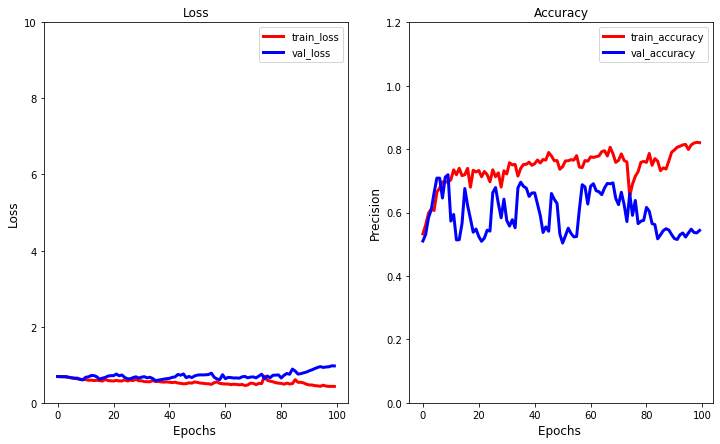

In [426]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'], 'r', linewidth=3.0) 
axs[0].plot(history.history['val_loss'], 'b', linewidth=3.0)
axs[0].legend(['train_loss', 'val_loss'], fontsize=10)
axs[0].set_xlabel('Epochs ', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].set_ylim(0,10)
axs[0].set_title('Loss', fontsize=12)

axs[1].plot(history.history['accuracy'], 'r', linewidth=3.0) 
axs[1].plot(history.history['val_accuracy'], 'b', linewidth=3.0)
axs[1].legend(['train_accuracy', 'val_accuracy'], fontsize=10)
axs[1].set_xlabel('Epochs ', fontsize=12)
axs[1].set_ylabel('Precision', fontsize=12) 
axs[1].set_ylim(0,1.2)
axs[1].set_title('Accuracy', fontsize=12)
plt.show()

# Evaluate the model

In [427]:
from metrics import confusion_matrix_sequencialOutput, confusion_matrix_sequencial_output_mean_std

### Training samples

In [428]:
TP, FP, TN, FN, conf_matrix = confusion_matrix_sequencialOutput(model, 
                                                                X_train, y_train, 
                                                                (gap_before_start_time + gap_after_start_time))

In [429]:
conf_matrix

array([[5123., 1331.],
       [ 171., 3005.]])

In [430]:
print("Accuracy training: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall training: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion training: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy training: 84.40%
Recall training: 96.77%
Precicion training: 79.38%


### Testing samples

In [431]:
TP, FP, TN, FN, conf_matrix = confusion_matrix_sequencialOutput(model, 
                                                                X_test, y_test, 
                                                                (gap_before_start_time + gap_after_start_time))

In [432]:
conf_matrix

array([[ 569.,  588.],
       [1315., 1698.]])

In [433]:
print("Accuracy testing: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall testing: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion testing: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy testing: 54.36%
Recall testing: 30.20%
Precicion testing: 49.18%


# Analysing similaritis

In [434]:
from metrics import similarity_sequential_output_percentage_correct, updated_detect_regulations_binary_mean_std

In [435]:
equal, similar, incorrect = similarity_sequential_output_percentage_correct(model, X_test, y_test, 90)

/home/sergi/Documents/PhD_Castelldefels/RNN_v8_weather_reims/metrics.py:248: RuntimeWarning: invalid value encountered in true_divide
  percentage_correct_predictions = sum_prediction / sum_test_sample
/home/sergi/Documents/PhD_Castelldefels/RNN_v8_weather_reims/metrics.py:248: RuntimeWarning: divide by zero encountered in true_divide
  percentage_correct_predictions = sum_prediction / sum_test_sample


In [436]:
equal, similar, incorrect

(0.4460431654676259, 0.17266187050359713, 0.381294964028777)

# From many-to-many to many-to-one

In [437]:
from metrics import detect_regulations_binary, updated_detect_regulations_binary

In [438]:
TP_binary, FP_binary, TN_binary, FN_binary, conf_matrix_binary = detect_regulations_binary(model, X_test, y_test)

In [439]:
conf_matrix_binary

array([[67., 19.],
       [ 0., 51.]])

In [440]:
print("Accuracy testing: %.2f" % ((TP_binary+TN_binary)/(TP_binary+FP_binary+FN_binary+TN_binary)*100) + "%")
print("Recall testing: %.2f" % (TP_binary/(TP_binary+FN_binary)*100) + "%")
print("Precicion testing: %.2f" % (TP_binary/(TP_binary+FP_binary)*100) + "%")

Accuracy testing: 86.13%
Recall testing: 100.00%
Precicion testing: 77.91%


In [441]:
TP_binary, FP_binary, TN_binary, FN_binary, conf_matrix_binary = updated_detect_regulations_binary(model, 
                                                                                                   X_test, 
                                                                                                   y_test, 
                                                                                                   1)

In [442]:
conf_matrix_binary

array([[37., 21.],
       [30., 51.]])

In [443]:
print("Accuracy testing: %.2f" % ((TP_binary+TN_binary)/(TP_binary+FP_binary+FN_binary+TN_binary)*100) + "%")
print("Recall testing: %.2f" % (TP_binary/(TP_binary+FN_binary)*100) + "%")
print("Precicion testing: %.2f" % (TP_binary/(TP_binary+FP_binary)*100) + "%")

Accuracy testing: 63.31%
Recall testing: 55.22%
Precicion testing: 63.79%


# Saving the model 


In [444]:
# model.save('./Counting_variables/Meeting_20210309')